In [1]:
import sys
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Setting library defaults

In [2]:
# code settings
pd.set_option('display.max_columns', None)

# visualization settings
plt.rc('figure', figsize=(9,9))
sns.set_style('darkgrid')

## Importing the Data

In [3]:
supp_county = pd.read_csv('../data/processed/supp_county.csv')

supp_county.head(5)

,FIPS,State,County,2010 Census Population,"Population Estimate, 2011","Population Estimate, 2012","Population Estimate, 2013","Population Estimate, 2014","Population Estimate, 2015","Population Estimate, 2016"
0,1001.0,Alabama,Autauga,"54,571","55,255","55,027","54,792","54,977","55,035","55,416"
1,1003.0,Alabama,Baldwin,"182,265","186,653","190,403","195,147","199,745","203,690","208,563"
2,1005.0,Alabama,Barbour,"27,457","27,326","27,132","26,938","26,763","26,270","25,965"
3,1007.0,Alabama,Bibb,"22,915","22,736","22,645","22,501","22,511","22,561","22,643"
4,1009.0,Alabama,Blount,"57,322","57,707","57,772","57,746","57,621","57,676","57,704"


A closer look at the most recent (2016) estimated population data for each county plotted against the 2010 census data. Most of the counties have fall along a line, which looks approximately like a slope of 1, meaning that the population change was minimal. Points outside of this pseudo-regression are counties whose population changed over the 6 year span. Points above the line are counties where population increased and points below the line are a decrease in population.   

([], <a list of 0 Text yticklabel objects>)

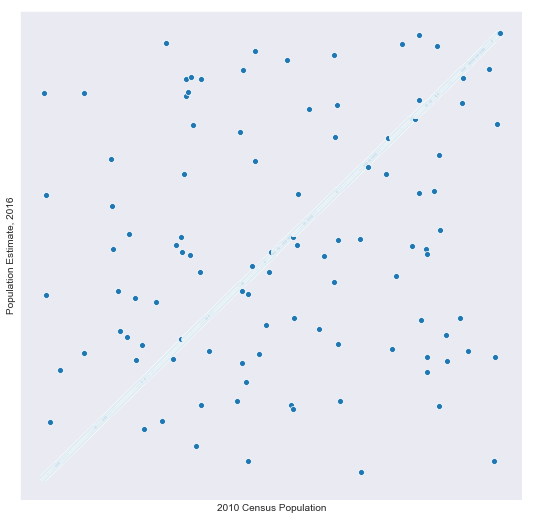

In [4]:
sns.scatterplot(x = '2010 Census Population', 
                y = 'Population Estimate, 2016',
                data = supp_county)

plt.xticks([])
plt.yticks([])

Change in state population

set state_pop09 as baseline.
take difference in population across years

Just do for pop_change
Need to reorganize data: convert wide format to long format
- years are columns
- State_fips and state_name 2 columns, repeating across all rows
- variable column


|state|variable  |2010|2011|...|2016|
|-----|----------|----|----|---|----|
|AL   |pop_change|XYZ |XYZ |...|XYZ |
|Az   |
|:    |
|:    |
|Wy   |pop_change|XYZ |XYZ |...|XYZ |


(x = year, y = popXY_change, hue = state)

In [3]:
supp_state = pd.read_csv('../data/processed/supp_state.csv')
supp_state = supp_state.dropna(0)

In [4]:
def str_to_int(start_col, end_col):
    """Converts column to int in place.
    
    Args:
        start_col(int): the first column to convert
        end_col(int): the last column to convert
    """
    for i in range(start_col, end_col):
        supp_state.iloc[:, i] = supp_state.iloc[:, i].str.replace(',', '')
        supp_state.iloc[:, i] = pd.to_numeric(supp_state.iloc[:, i])

In [5]:
str_to_int(2, len(supp_state.columns))

In [6]:
supp_state['pop10_change'] = supp_state['State Population, 2009'] - supp_state['State Population, 2010']
supp_state['pop11_change'] = supp_state['State Population, 2009'] - supp_state['State Population, 2011']
supp_state['pop12_change'] = supp_state['State Population, 2009'] - supp_state['State Population, 2012']
supp_state['pop13_change'] = supp_state['State Population, 2009'] - supp_state['State Population, 2013']
supp_state['pop14_change'] = supp_state['State Population, 2009'] - supp_state['State Population, 2014']
supp_state['pop15_change'] = supp_state['State Population, 2009'] - supp_state['State Population, 2015']
supp_state['pop16_change'] = supp_state['State Population, 2009'] - supp_state['State Population, 2016']

In [22]:
pop_change = supp_state[['StateFIPS',
                         'State',
                         'pop10_change',
                         'pop11_change',
                         'pop12_change',
                         'pop13_change',
                         'pop14_change',
                         'pop15_change',
                         'pop16_change']]

In [25]:
test = pop_change.rename(index=str, columns={'pop10_change': '2010',
                                            'pop11_change': '2011',
                                            'pop12_change': '2012',
                                            'pop13_change': '2013',
                                            'pop14_change': '2014',
                                            'pop15_change': '2015',
                                            'pop16_change': '2016'})

test = pd.melt(test, 
               id_vars=['State'], 
               value_vars=['2010', '2011', '2012',
                           '2013', '2014', '2015', '2016'])

test.head(1)

,State,variable,value
0,Alabama,2010,-76693


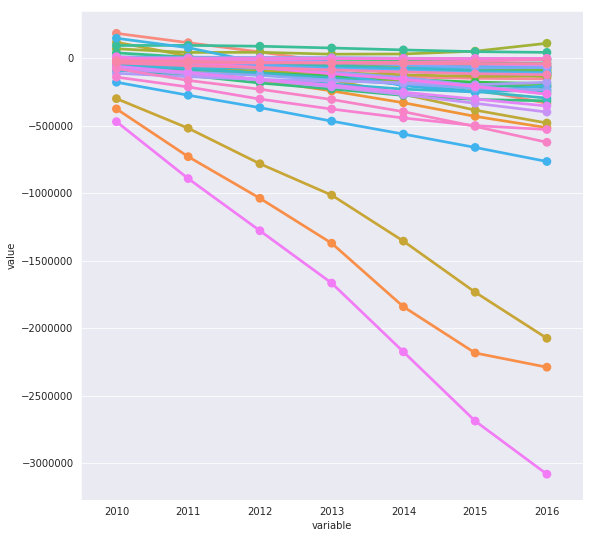

In [28]:
pop_plot = sns.pointplot(x = 'variable', y = 'value', hue = 'State', data = test)

pop_plot.legend_.remove()

plt.show()

In [16]:
pop_change.head(4)

,StateFIPS,State,pop10_change,pop11_change,pop12_change,pop13_change,pop14_change,pop15_change
0,1.0,Alabama,-76693,-94032,-108820,-125014,-140669,-150271
1,2.0,Alaska,-15673,-24245,-31834,-36659,-38259,-39959
2,4.0,Arizona,182620,113273,44629,-30846,-135706,-232287
3,5.0,Arkansas,-32138,-48529,-60378,-69923,-76919,-88754


Types of plots

correlation plots for all datasets
